In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import csv
import time
import cv2
import imageio
import pylab
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import scipy.misc
import time
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow.tools.graph_transforms import TransformGraph
from keras import backend as K
import math

#if tf.__version__ < '1.4.0':
#  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
print('done')

done


Using TensorFlow backend.


In [2]:
ROOT = os.getcwd()
# What model to download.
MODEL_PATH = 'Model/800img2.pb'
#Path to input images
PATH_TO_TEST_IMAGES = 'output/'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'labelmap.pbtxt')

OUTPUT_PATH = 'output/'
threshold = 0.1

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(MODEL_PATH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
print('done')

done


In [4]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [5]:
def draw_rect(img_name,name,xmin,ymin,xmax,ymax,score,color):
    image =img_name
    im = np.array(image, dtype=np.uint8)
    cv2.rectangle(im,(xmax,ymax),(xmin,ymin),color,1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im,str(score),(xmin,ymin), font, 0.4,(255,255,255),1,cv2.LINE_AA)
    img = Image.new("RGB",(image.shape[1],image.shape[0]))
    img = Image.fromarray(im, 'RGB')
    #plt.imshow(img)
    img.save(name)
    return img

In [43]:
def run_inference_for_multiple_image(images, graph,cropsize=-1):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      for image_path in images:
          print(image_path)
          image = Image.open(image_path)
          
          #Run inference
#           image_np = load_image_into_numpy_array(image)
#           if cropsize>-1:
#               image_np = image_np[0:cropsize,0:cropsize]
#           image_np_expanded = np.expand_dims(image, axis=0)
          if cropsize>-1:
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)[0:cropsize,0:cropsize]})
          else:
              output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

#           print(output_dict['detection_scores'])
          # all outputs are float32 numpy arrays, so convert types as appropriate
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]
          if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
          count = 0
          for box,classes,score in zip(output_dict['detection_boxes'],output_dict['detection_classes'],output_dict['detection_scores']):
            #Drawing boxes takes a long time!!!
            if score >1.0:
                ymin,xmin,ymax,xmax = box
                xmin,xmax= converse(xmin,xmax,image.size[0])
                ymin,ymax= converse(ymin,ymax,image.size[1])
                image = draw_rect(np.array(image),image_path,xmin,ymin,xmax,ymax,score,(255,255,255))
      #saver.save(sess,graphOutputTest)
  return output_dict
print('done')


done


## 100 runs time consumption

### processing 100 images

run took: 9.445 sec on 100 images --> average of: 0.0945 sec per image

### including loading of the images

run took: 29.30 on 100 images --> average of: 0.2930 sec per image

In [20]:
def converse(xmin,xmax,x):
    return int(xmin*x),int(xmax*x)

In [42]:
output_dict = run_inference_for_multiple_image(['eval/test/hori00007.png'],detection_graph,200)

eval/test/hori00007.png
(1, 200, 200, 3)


In [48]:
images =[]
nr_of_img = 0
start = time.time()
for i in range (0,1):
    for  img_path in os.listdir('eval/testNewWithBrightnessTraining/'):
        if img_path.endswith('.png'):
            images.append('eval/testNewWithBrightnessTraining/'+img_path)
            nr_of_img+=1
            
            
            image = Image.open('eval/testNewWithBrightnessTraining/'+img_path)
          #Run inference
            image_np_expanded = np.expand_dims(image, axis=0)
            print(img_path)

total_time = time.time()-start

print('run took: {} on {} images --> average of: {}'.format(total_time,nr_of_img, total_time/nr_of_img))

hori00017.png
hori00007.png
ori00007.png
ori00018.png
hori00013.png
turn00009.png
turn00000.png
vert00024.png
ori00029.png
turn00026.png
ori00006.png
ori00004.png
vert00010.png
hori00025.png
turn00028.png
ori00021.png
ori00025.png
turn00037.png
ori00034.png
ori00011.png
vert00003.png
ori00032.png
vert00029.png
ori00039.png
vert00033.png
vert00005.png
ori00010.png
turn00039.png
vert00001.png
turn00022.png
ori00005.png
ori00028.png
vert00020.png
turn00040.png
turn00002.png
vert00006.png
hori00019.png
turn00007.png
vert00039.png
vert00019.png
turn00018.png
turn00013.png
hori00012.png
hori00034.png
turn00025.png
turn00038.png
run took: 0.6171987056732178 on 46 images --> average of: 0.013417363166809082


In [39]:
images = []
nr_of_img=0
for i in range (0,1):
    for  img_path in os.listdir('eval/testNewWithBrightnessTraining/'):
        if img_path.endswith('.png'):
            images.append('eval/testNewWithBrightnessTraining/'+img_path)
            nr_of_img+=1

start = time.time()

output_dict = run_inference_for_multiple_image(images,detection_graph)
total_time = time.time()-start
print('run took: {} on {} images --> average of: {}'.format(total_time,nr_of_img, total_time/nr_of_img))


# GPU with drawing:
#[-1, -1, 512, 256, 256, 128]
#run took: 67.40675640106201 on 230 images --> average of: 0.2930728539176609
#run took: 7.138956785202026 on 23 images --> average of: 0.31038942544356635

#[-1, -1, 256, 128, 128, 64]
#run took: 63.65955138206482 on 230 images --> average of: 0.2767806581828905

#[-1, -1, 256, 128, 0, 0]
#run took: 74.49321842193604 on 230 images --> average of: 0.3238835583562436

#'Model/prop4size150.pb'
#run took: 11.74824857711792 on 46 images --> average of: 0.25539670819821564
#run took: 172.33490419387817 on 162 images --> average of: 1.0637957049004825

#'Model/prop4size250.pb'
#
#run took: 161.92876768112183 on 162 images --> average of: 0.9995602943279125

##'Model/prop4size350.pb'


eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/hori00012.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00019.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/hori00034.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/ori00005.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00010.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/ori00028.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/ori00032.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTrainin

eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/turn00038.png
eval/testNewWithBrightnessTraining/turn00039.png
eval/testNewWithBrightnessTraining/turn00040.png
eval/testNewWithBrightnessTraining/vert00001.png
eval/testNewWithBrightnessTraining/vert00003.png
eval/testNewWithBrightnessTraining/vert00005.png
eval/testNewWithBrightnessTraining/vert00006.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/vert00019.png
eval/testNewWithBrightnessTraining/vert00020.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/vert00029.png
eval/testNewWithBrightnessTraining/vert00033.png
eval/testNewWithBrightnessTraining/vert00039.png
run took: 51.56584882736206 on 184 images --> average of: 0.2802491784095764


# Visualizing layers

In [16]:
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}
print(all_tensor_names)

{'FeatureExtractor/MobilenetV2/layer_19_2_Conv2d_3_3x3_s2_256_depthwise/BatchNorm/batchnorm/add:0', 'FeatureExtractor/MobilenetV2/layer_19_1_Conv2d_4_1x1_128/BatchNorm/batchnorm/mul:0', 'MultipleGridAnchorGenerator/Meshgrid_1/Rank_1:0', 'MultipleGridAnchorGenerator/Meshgrid_2/ExpandedShape_1/Reshape/shape:0', 'MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/ones:0', 'MultipleGridAnchorGenerator/mul_54:0', 'BoxPredictor_3/Shape:0', 'MultipleGridAnchorGenerator/Meshgrid_4/ExpandedShape/Reshape:0', 'FeatureExtractor/MobilenetV2/expanded_conv_2/expand/Conv2D:0', 'MultipleGridAnchorGenerator/ToFloat_8/x:0', 'BoxPredictor_4/BoxEncodingPredictor_depthwise/BatchNorm/moving_mean:0', 'MultipleGridAnchorGenerator/Meshgrid_7/Rank:0', 'MultipleGridAnchorGenerator/Meshgrid_12/ExpandedShape/ones/Const:0', 'FeatureExtractor/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0', 'Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/cond/ExpandDims:0', 'FeatureExtractor/Mo

Tensor("FeatureExtractor/MobilenetV2/expanded_conv_4/expansion_output:0", shape=(?, ?, ?, 192), dtype=float32)
activation shape = (1, 38, 38, 192)
showing 100 out of 192 
original shape = (1, 584, 582, 3)


c:\users\berger\appdata\local\continuum\anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


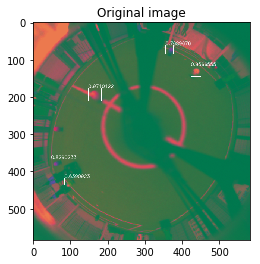

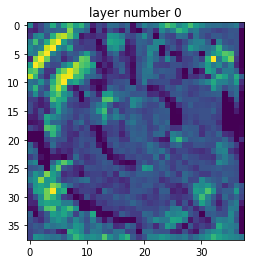

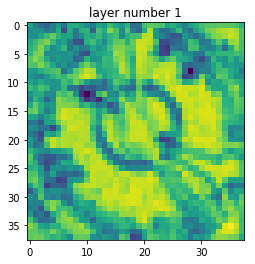

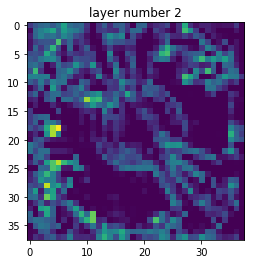

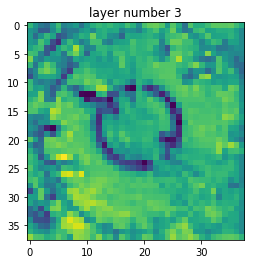

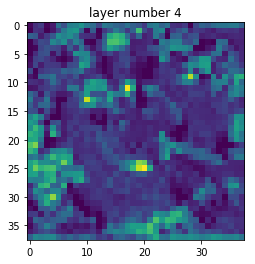

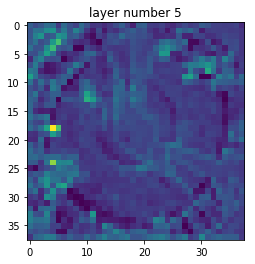

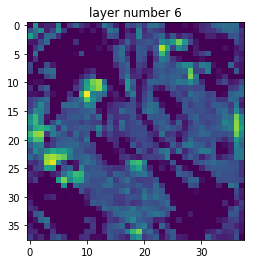

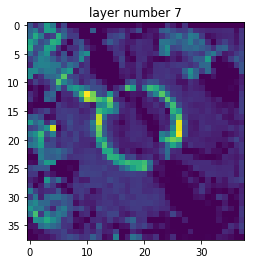

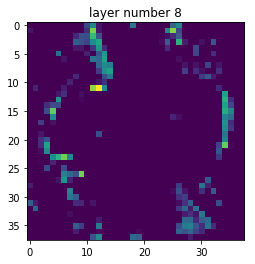

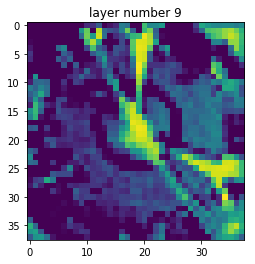

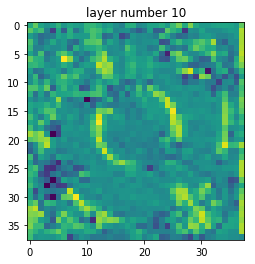

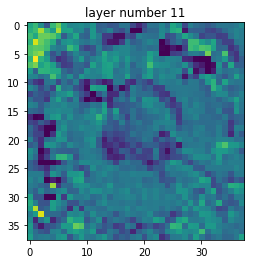

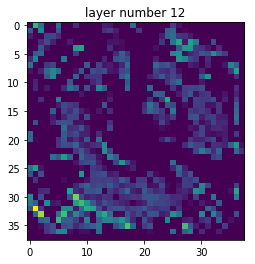

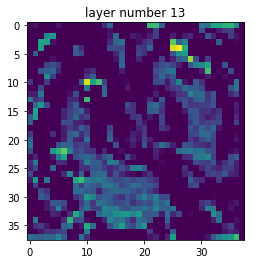

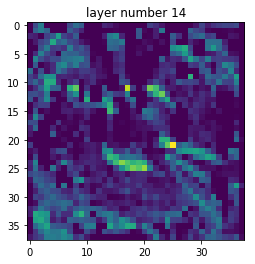

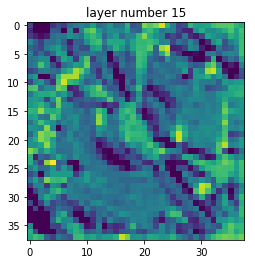

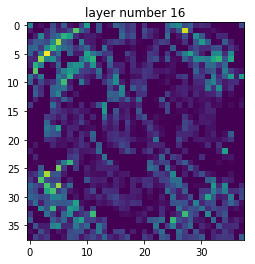

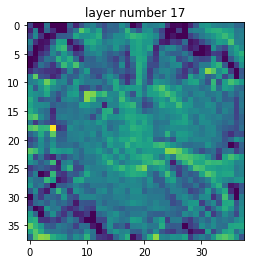

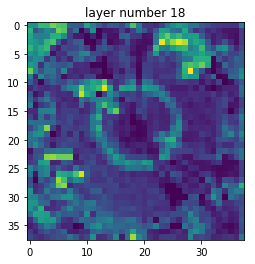

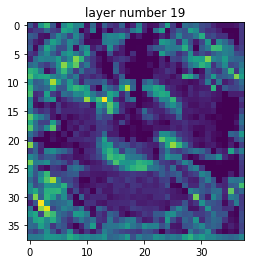

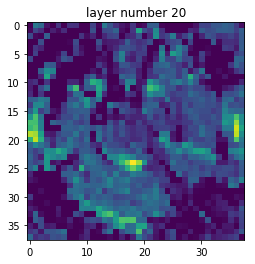

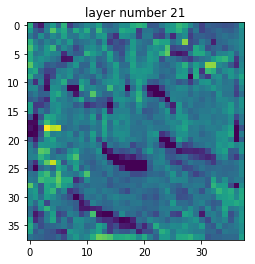

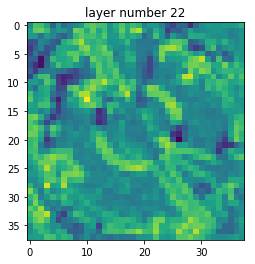

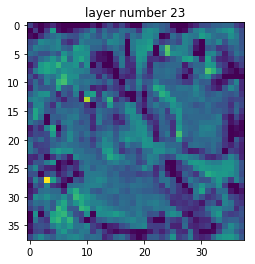

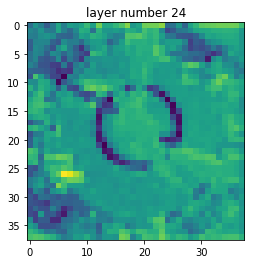

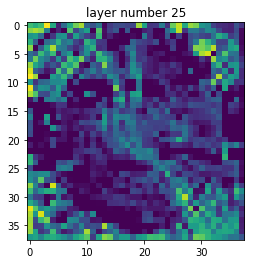

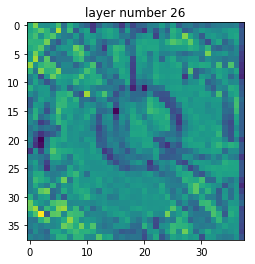

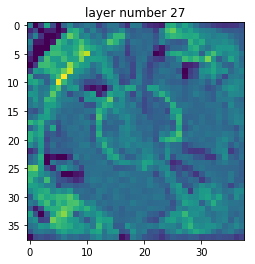

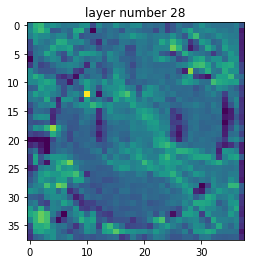

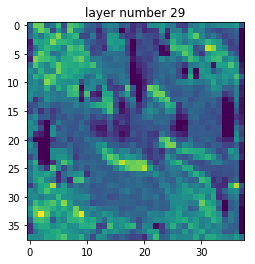

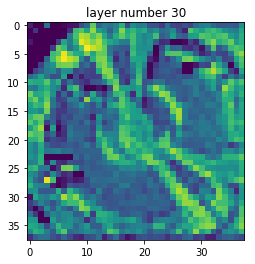

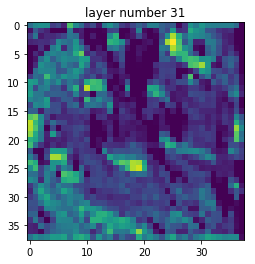

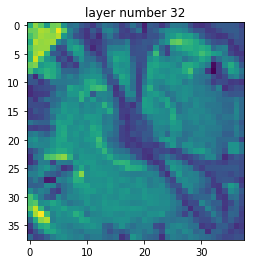

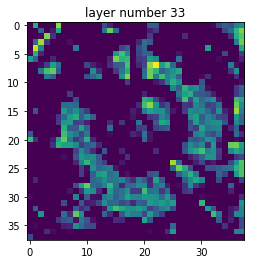

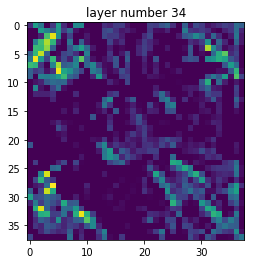

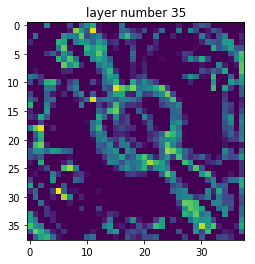

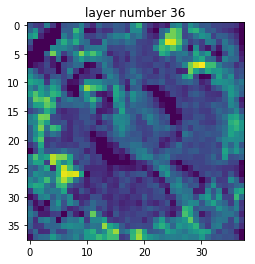

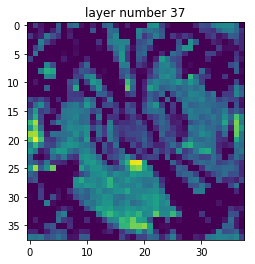

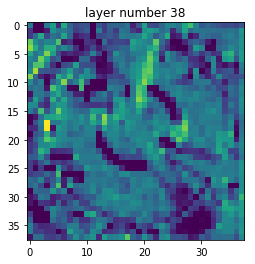

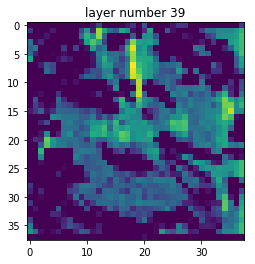

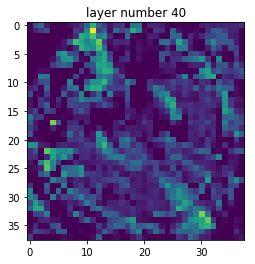

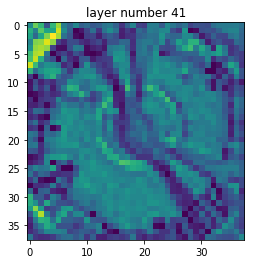

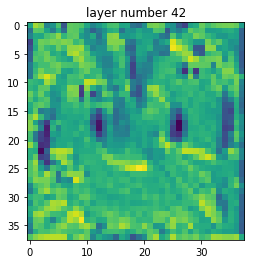

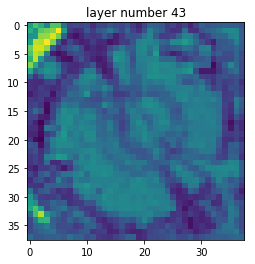

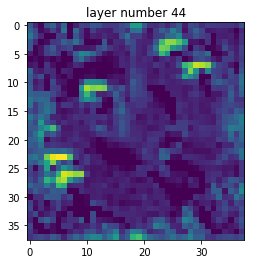

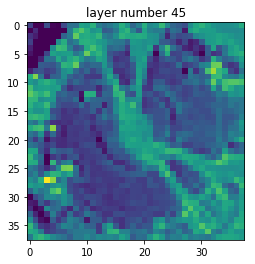

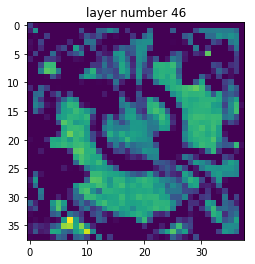

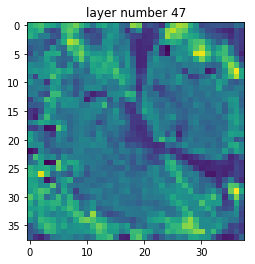

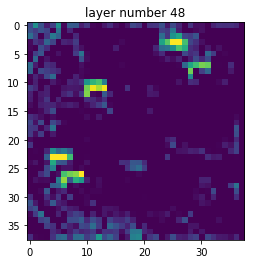

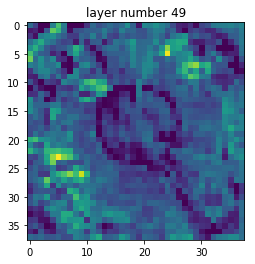

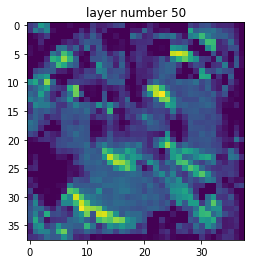

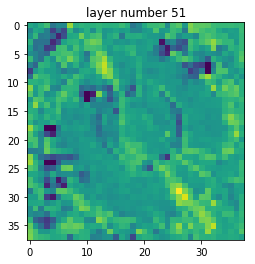

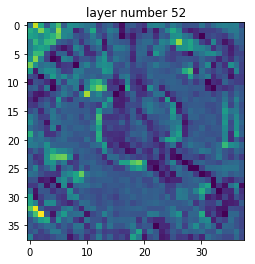

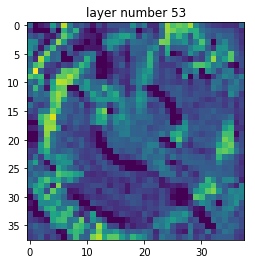

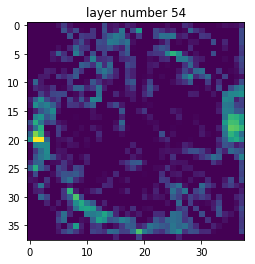

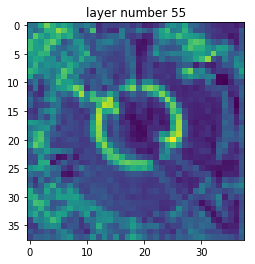

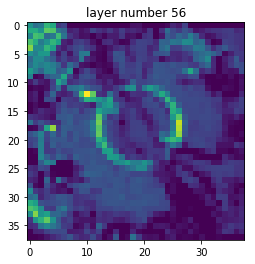

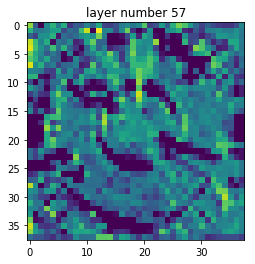

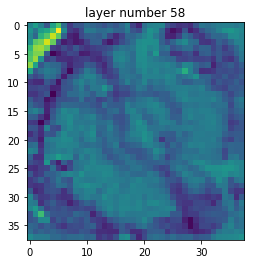

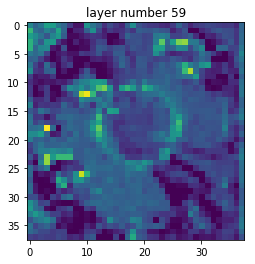

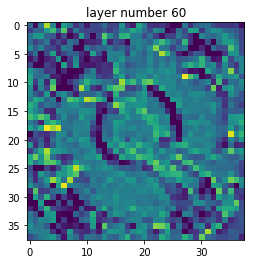

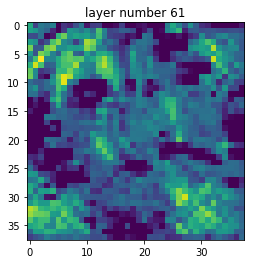

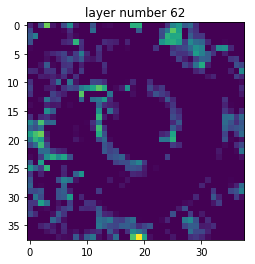

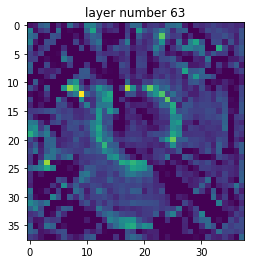

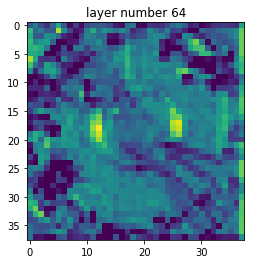

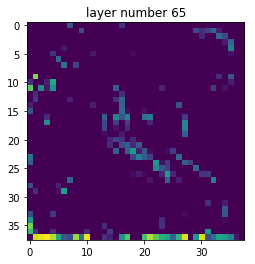

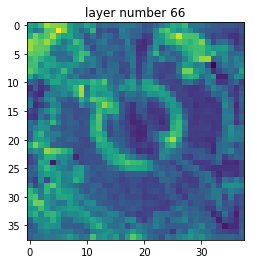

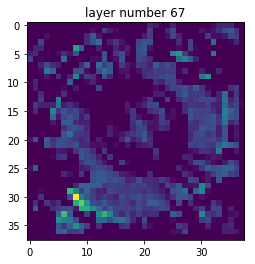

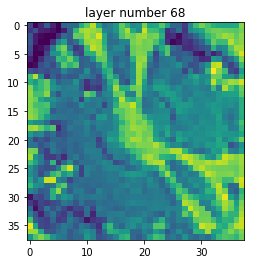

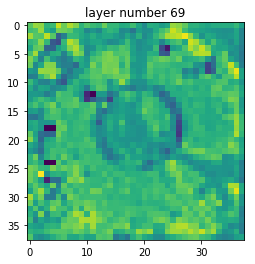

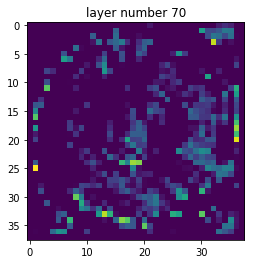

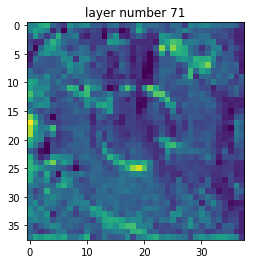

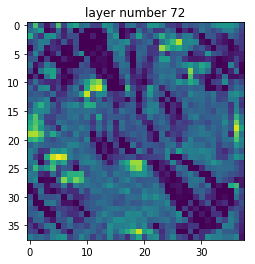

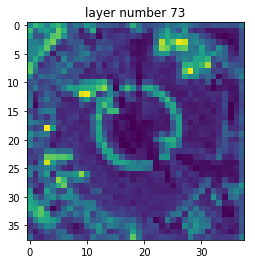

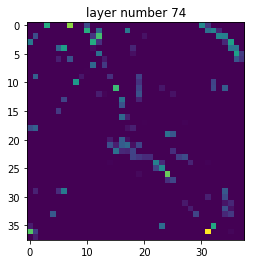

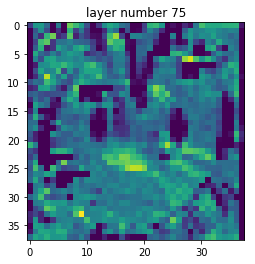

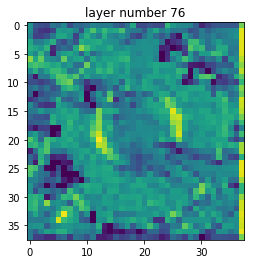

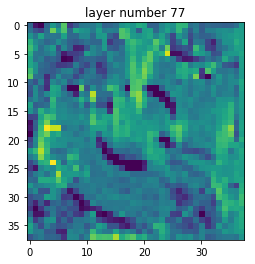

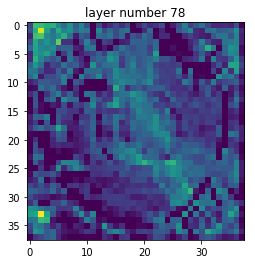

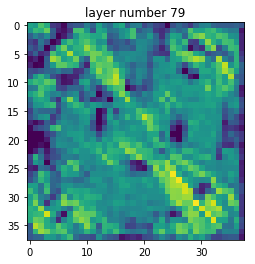

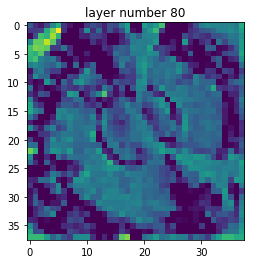

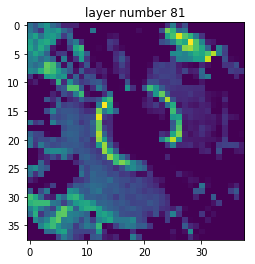

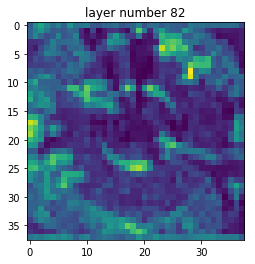

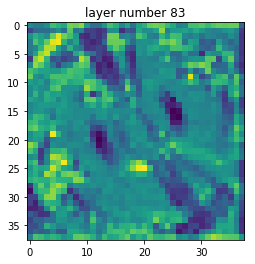

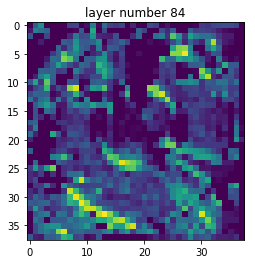

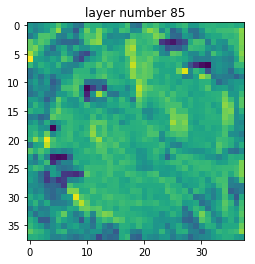

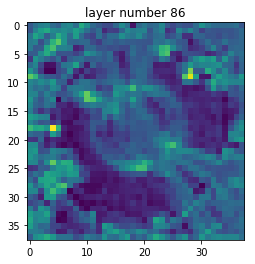

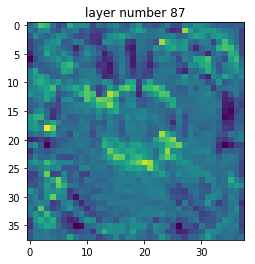

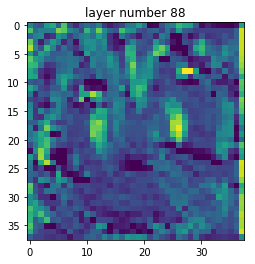

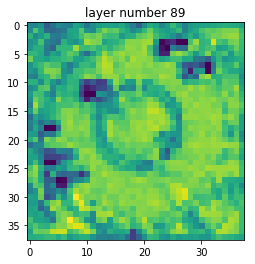

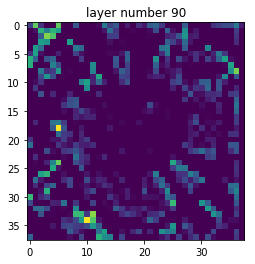

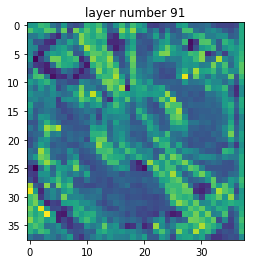

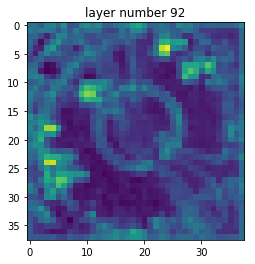

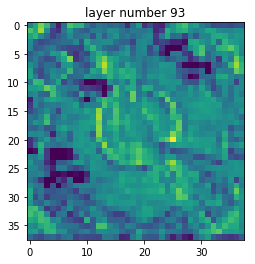

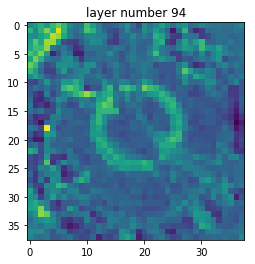

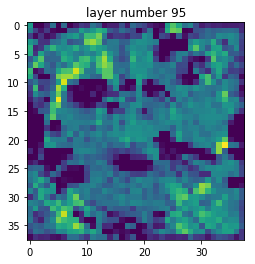

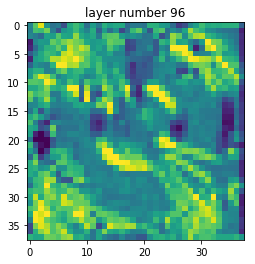

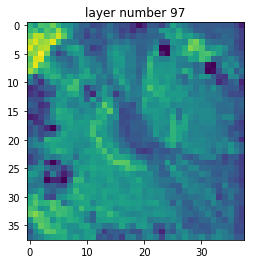

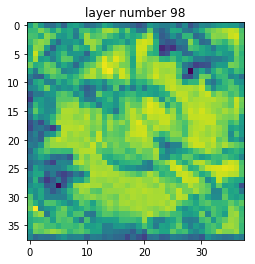

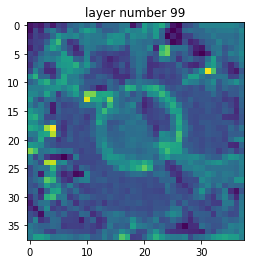

<Figure size 432x288 with 0 Axes>

In [36]:
inptdata = np.expand_dims(np.array(Image.open('eval/800/hori00023.png')),axis=0)


input_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}

for tensor in all_tensor_names:
    if 'expanded_conv_4/expansion_output:0' in tensor:
        output_tensor =detection_graph.get_tensor_by_name(tensor)
        print(output_tensor)

with detection_graph.as_default():
    with tf.Session() as sess:
        # layer = model.layers[8]
        f = K.function([input_tensor], [output_tensor])
#         print(inptdata.shape)
        activation = f([inptdata])[0]  # your activation tensor

        print('activation shape = {}'.format(activation.shape))
        number_of_prints =100



        def plot_1_dim():
            for i in range(0,number_of_prints):
                print(activation[0,i])



        def plot ():
            plt.title('Original image')
            print('original shape = {}'.format(inptdata.shape))
            plt.imshow(inptdata[0])
            plt.figure()
            for i in range(0,min(len(activation[0,0,0,:]),number_of_prints)):
#                 print(activation.shape)
                plt.title('layer number {}'.format(i))
#                 print(len())
                plt.imshow(activation[0,:,:,i])
                plt.figure()


        if(len(activation.shape)==2):
            print('showing {} out of {} '.format(min(len(activation),number_of_prints),len(activation)))
            plot_1_dim()
        else:
            print('showing {} out of {} '.format(min(len(activation[0,0,0,:]),number_of_prints),activation.shape[-1]))
            plot()

# Evaluating IoU

In [33]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  2 16:09:05 2018

@author: Berger
"""    
from PIL import Image
import numpy as np
import cv2
import csv


def get_intersect(pred_coords,true_coords):
    pred_coords=[float(i) for i in pred_coords]
    true_coords=[float(i) for i in true_coords]
    
    predicted_surface = (pred_coords[2]-pred_coords[0])*(pred_coords[3]-pred_coords[1])
    true_surface = (true_coords[2]-true_coords[0])*(true_coords[3]-true_coords[1])
    
    intersect_ymin = max(pred_coords[1], true_coords[0])
    intersect_xmin = max(pred_coords[0], true_coords[1])
    intersect_ymax = min(pred_coords[3], true_coords[2])
    intersect_xmax = min(pred_coords[2], true_coords[3])
    
    intersect_surface = max(0,  intersect_ymax-intersect_ymin ) * max(0, intersect_xmax - intersect_xmin)
    return intersect_surface/float(predicted_surface+true_surface-intersect_surface)

In [12]:
MODEL_PATH = 'Model/800img2.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(MODEL_PATH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
print('done')

done


In [35]:


x = []
IoU = []
total = 0
pred_list = []
items = 0
FN =0
IoU_threshold =0.2
images=0

with open('eval/test/test_labels.csv') as a:
    true_reader=csv.reader(a,delimiter=',');
    next(true_reader)
    old_name = "placeholder"
    for true_row in true_reader:
        temp_IoU = 0
        if(old_name!=true_row[0]):
            pred_list = run_inference_for_multiple_image(['eval/test/'+true_row[0]],detection_graph)['detection_boxes']
            images+=1
            old_name = true_row[0]
            
        for pred_row in pred_list:
            temp_IoU = max(temp_IoU, get_intersect(true_row[4:],[x*583 for x in pred_row]))
        if temp_IoU<IoU_threshold :
            #draw_rect(root+true_row[0].split('/')[-1],int(true_row[4]),int(true_row[5]),int(true_row[6]),int(true_row[7]))
            FN+=1
            #print(true_row[0].split('/')[-1]+' ' +str(temp_IoU)+ ' ' + ' '.join(true_row[4:]))
        #print('{} has a temp IoU of {}'.format(true_row[0],temp_IoU))
        total+=temp_IoU
        items+=1

#divide by 2 because of the wrong true labels dataset
items = int((items-1)/2)
FN = int(FN/2)
print('Evaluated {} images with a total of {} objects'.format(images,items))
print('Average IoU -> total IoU/#items: {}/{} = {}'.format(total,items,total/items))
print('False Negatives (based on {} IoU)= {}'.format(IoU_threshold,FN) )
            
#print(get_intersect(pred_coords,true_coords))

eval/test/hori00007.png
eval/test/hori00013.png
eval/test/hori00017.png
eval/test/hori00019.png
eval/test/hori00025.png
eval/test/hori00034.png
eval/test/ori00004.png
eval/test/ori00006.png
eval/test/ori00007.png
eval/test/ori00011.png
eval/test/ori00021.png
eval/test/ori00028.png
eval/test/ori00029.png
eval/test/turn00000.png
eval/test/turn00002.png
eval/test/turn00007.png
eval/test/turn00013.png
eval/test/turn00018.png
eval/test/turn00025.png
eval/test/turn00028.png
eval/test/turn00039.png
eval/test/vert00001.png
eval/test/vert00006.png
eval/test/vert00010.png
eval/test/vert00019.png
eval/test/vert00020.png
eval/test/vert00024.png
eval/test/vert00029.png
Evaluated 28 images with a total of 105 objects
Average IoU -> total IoU/#items: 62.216441911756164/105 = 0.5925375420167254
False Negatives (based on 0.2 IoU)= 42


## Results

|Variables|IoU|
|------|------|
|prop4size150|0.3188|
|prop4size250|0.4491|
|prop4size350|0.2720|
|prop100size150|0.3073|
|prop100size250|0.3188|
|prop100size350|0.4010|
|800img2|0.59|

# Evaluation of datacropping

## no cropping

In [44]:
images = []
nr_of_img=0
for i in range (0,1):
    for  img_path in os.listdir('eval/testNewWithBrightnessTraining/'):
        if img_path.endswith('.png'):
            images.append('eval/testNewWithBrightnessTraining/'+img_path)
            nr_of_img+=1

start = time.time()

output_dict = run_inference_for_multiple_image(images,detection_graph)
total_time = time.time()-start
print('run took: {} on {} images --> average of: {}'.format(total_time,nr_of_img, total_time/nr_of_img))


eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/turn00009.png
eval/testNewWithBrightnessTraining/turn00000.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/turn00026.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/turn00028.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTra

## crop to 300 x 300

In [45]:
images = []
nr_of_img=0
for i in range (0,4):
    for  img_path in os.listdir('eval/testNewWithBrightnessTraining/'):
        if img_path.endswith('.png'):
            images.append('eval/testNewWithBrightnessTraining/'+img_path)
            nr_of_img+=1

start = time.time()

output_dict = run_inference_for_multiple_image(images,detection_graph,300)
total_time = time.time()-start
print('run took: {} on {} images --> average of: {}'.format(total_time,nr_of_img, total_time/nr_of_img))


eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/turn00009.png
eval/testNewWithBrightnessTraining/turn00000.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/turn00026.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/turn00028.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTra

eval/testNewWithBrightnessTraining/vert00020.png
eval/testNewWithBrightnessTraining/turn00040.png
eval/testNewWithBrightnessTraining/turn00002.png
eval/testNewWithBrightnessTraining/vert00006.png
eval/testNewWithBrightnessTraining/hori00019.png
eval/testNewWithBrightnessTraining/turn00007.png
eval/testNewWithBrightnessTraining/vert00039.png
eval/testNewWithBrightnessTraining/vert00019.png
eval/testNewWithBrightnessTraining/turn00018.png
eval/testNewWithBrightnessTraining/turn00013.png
eval/testNewWithBrightnessTraining/hori00012.png
eval/testNewWithBrightnessTraining/hori00034.png
eval/testNewWithBrightnessTraining/turn00025.png
eval/testNewWithBrightnessTraining/turn00038.png
run took: 8.573432445526123 on 184 images --> average of: 0.04659474155177241


## crop to 200 x 200

In [46]:
images = []
nr_of_img=0
for i in range (0,4):
    for  img_path in os.listdir('eval/testNewWithBrightnessTraining/'):
        if img_path.endswith('.png'):
            images.append('eval/testNewWithBrightnessTraining/'+img_path)
            nr_of_img+=1

start = time.time()

output_dict = run_inference_for_multiple_image(images,detection_graph,200)
total_time = time.time()-start
print('run took: {} on {} images --> average of: {}'.format(total_time,nr_of_img, total_time/nr_of_img))

eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/turn00009.png
eval/testNewWithBrightnessTraining/turn00000.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/turn00026.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/turn00028.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTra

eval/testNewWithBrightnessTraining/turn00040.png
eval/testNewWithBrightnessTraining/turn00002.png
eval/testNewWithBrightnessTraining/vert00006.png
eval/testNewWithBrightnessTraining/hori00019.png
eval/testNewWithBrightnessTraining/turn00007.png
eval/testNewWithBrightnessTraining/vert00039.png
eval/testNewWithBrightnessTraining/vert00019.png
eval/testNewWithBrightnessTraining/turn00018.png
eval/testNewWithBrightnessTraining/turn00013.png
eval/testNewWithBrightnessTraining/hori00012.png
eval/testNewWithBrightnessTraining/hori00034.png
eval/testNewWithBrightnessTraining/turn00025.png
eval/testNewWithBrightnessTraining/turn00038.png
run took: 8.679145097732544 on 184 images --> average of: 0.04716926683550295


## crop to 100 x 100

In [47]:
images = []
nr_of_img=0
for i in range (0,4):
    for  img_path in os.listdir('eval/testNewWithBrightnessTraining/'):
        if img_path.endswith('.png'):
            images.append('eval/testNewWithBrightnessTraining/'+img_path)
            nr_of_img+=1

start = time.time()

output_dict = run_inference_for_multiple_image(images,detection_graph,100)
total_time = time.time()-start
print('run took: {} on {} images --> average of: {}'.format(total_time,nr_of_img, total_time/nr_of_img))

eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/turn00009.png
eval/testNewWithBrightnessTraining/turn00000.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/turn00026.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/turn00028.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTra

eval/testNewWithBrightnessTraining/vert00020.png
eval/testNewWithBrightnessTraining/turn00040.png
eval/testNewWithBrightnessTraining/turn00002.png
eval/testNewWithBrightnessTraining/vert00006.png
eval/testNewWithBrightnessTraining/hori00019.png
eval/testNewWithBrightnessTraining/turn00007.png
eval/testNewWithBrightnessTraining/vert00039.png
eval/testNewWithBrightnessTraining/vert00019.png
eval/testNewWithBrightnessTraining/turn00018.png
eval/testNewWithBrightnessTraining/turn00013.png
eval/testNewWithBrightnessTraining/hori00012.png
eval/testNewWithBrightnessTraining/hori00034.png
eval/testNewWithBrightnessTraining/turn00025.png
eval/testNewWithBrightnessTraining/turn00038.png
run took: 8.740479946136475 on 184 images --> average of: 0.047502608402915626


# Dataset estimator


In [5]:
ds = tf.data.TextLineDataset('Data/DataSet/train_labels.csv').skip(1)

In [30]:
# Metadata describing the text columns
COLUMNS = ['filename', 'width',
           'height', 'class',
           'xmin','ymin',
          'xmax','ymax']
FIELD_DEFAULTS = [[''], [0.0], [0.0], [''],[0.0], [0.0], [0.0],[0.0]]
def _parse_line(line):
    # Decode the line into its fields
    fields = tf.decode_csv(line, FIELD_DEFAULTS)

    # Pack the result into a dictionary
    features = dict(zip(COLUMNS,fields))
#     print(features)
    # Separate the label from the features
    label = features.pop('class')

    return features, label

In [29]:
updated_ds = ds.map(_parse_line)

{'filename': <tf.Tensor 'DecodeCSV:0' shape=() dtype=string>, 'ymin': <tf.Tensor 'DecodeCSV:5' shape=() dtype=float32>, 'width': <tf.Tensor 'DecodeCSV:1' shape=() dtype=float32>, 'xmax': <tf.Tensor 'DecodeCSV:6' shape=() dtype=float32>, 'class': <tf.Tensor 'DecodeCSV:3' shape=() dtype=string>, 'ymax': <tf.Tensor 'DecodeCSV:7' shape=() dtype=float32>, 'xmin': <tf.Tensor 'DecodeCSV:4' shape=() dtype=float32>, 'height': <tf.Tensor 'DecodeCSV:2' shape=() dtype=float32>}


In [64]:
def train_input_fn(train_path,batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    
    ds = tf.data.TextLineDataset(train_path)
    ds = ds.map(_parse_line)
    # Shuffle, repeat, and batch the examples.
    dataset = ds.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

In [65]:
dataset =train_input_fn('Data/DataSet/train_labels.csv',1)

In [83]:
with detection_graph.as_default():
    with tf.Session() as sess:
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        
        output_dict = sess.run(tensor_dict,feed_dict={image_tensor: dataset})
        print(output_dict)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'BatchDataset'

# Graph optimization (Ubuntu Only)
Resulting times are about the same. This indicates that export_inference_graph.py already uses optimize for inference.

In [54]:
start = time.time()

output_dict = run_inference_for_multiple_image(images,detection_graph)
total_time = time.time()-start
print(total_time/len(images))

eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/turn00009.png
eval/testNewWithBrightnessTraining/turn00000.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/turn00026.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/turn00028.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTra

In [55]:
inputGraph = tf.GraphDef()
with tf.gfile.Open("800img2.pb", "rb") as f:
    data2read = f.read()
    inputGraph.ParseFromString(data2read)

In [56]:
outputGraph = optimize_for_inference_lib.optimize_for_inference(
                inputGraph,
                ["image_tensor"], # an array of the input node(s)
                ["detection_boxes"], # an array of output nodes
                tf.int8.as_datatype_enum)
f = tf.gfile.FastGFile("800img2optimized.pb", "w")
f.write(outputGraph.SerializeToString())    


In [57]:
optimized_detection_graph = tf.Graph()
with optimized_detection_graph.as_default():
  od_graph_def = outputGraph
  with tf.gfile.GFile('800img2.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
print('done')

done


In [58]:
start = time.time()

output_dict = run_inference_for_multiple_image(images,optimized_detection_graph)
total_time = time.time()-start
print(total_time/len(images))

eval/testNewWithBrightnessTraining/hori00017.png
eval/testNewWithBrightnessTraining/hori00007.png
eval/testNewWithBrightnessTraining/ori00007.png
eval/testNewWithBrightnessTraining/ori00018.png
eval/testNewWithBrightnessTraining/hori00013.png
eval/testNewWithBrightnessTraining/turn00009.png
eval/testNewWithBrightnessTraining/turn00000.png
eval/testNewWithBrightnessTraining/vert00024.png
eval/testNewWithBrightnessTraining/ori00029.png
eval/testNewWithBrightnessTraining/turn00026.png
eval/testNewWithBrightnessTraining/ori00006.png
eval/testNewWithBrightnessTraining/ori00004.png
eval/testNewWithBrightnessTraining/vert00010.png
eval/testNewWithBrightnessTraining/hori00025.png
eval/testNewWithBrightnessTraining/turn00028.png
eval/testNewWithBrightnessTraining/ori00021.png
eval/testNewWithBrightnessTraining/ori00025.png
eval/testNewWithBrightnessTraining/turn00037.png
eval/testNewWithBrightnessTraining/ori00034.png
eval/testNewWithBrightnessTraining/ori00011.png
eval/testNewWithBrightnessTra